# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

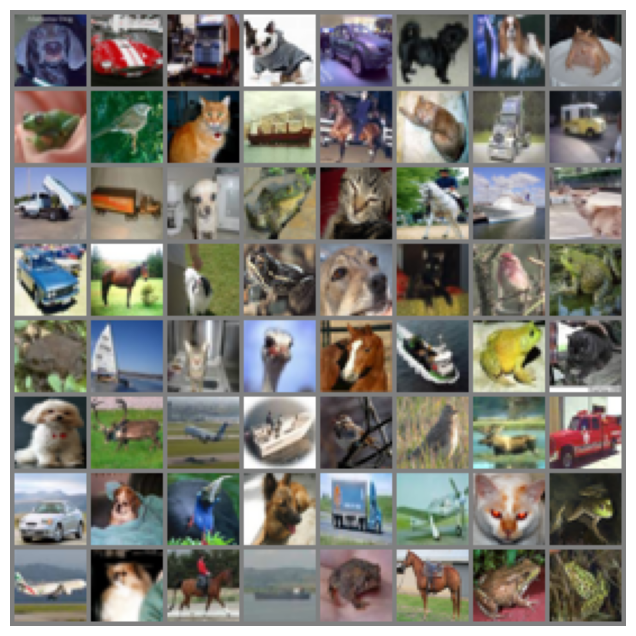

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),

            # Adjusted input size for the fully connected layer
            nn.Linear(64 * 7 * 7, 128),
            activation_fn(),

            nn.Linear(128, 128),
            activation_fn(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

Output shape: torch.Size([2, 10])


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.03999854  0.01859137  0.04264782 -0.00657542 -0.005216    0.06631065
   0.08966224  0.06830862 -0.04844628  0.04070693]
 [ 0.02923781  0.03019032  0.05996545 -0.00290215  0.00841099  0.07665123
   0.09253221  0.08604674 -0.01683162  0.0280164 ]]
Output probabilities:
[[0.10086628 0.09872997 0.10113386 0.09627625 0.09640722 0.10355551
  0.10600214 0.10376262 0.09232831 0.10093776]
 [0.09895091 0.09904521 0.10203863 0.09582119 0.09691139 0.10375551
  0.1054164  0.10473493 0.09449571 0.09883012]]


In [8]:
batch_size = 64
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad() # Zero gradients.
        
        output = model(inputs) # Forward pass.
        
        loss = loss_fn(output, targets) # Compute loss.
        
        loss.backward() # Compute gradients.
        
        optimizer.step() # Update parameters.
        
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.437125
             test accuracy: 0.5431
Step 1000    training accuracy: 0.6148939220183486
             test accuracy: 0.6161
Step 1500    training accuracy: 0.64515625
             test accuracy: 0.6344
Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

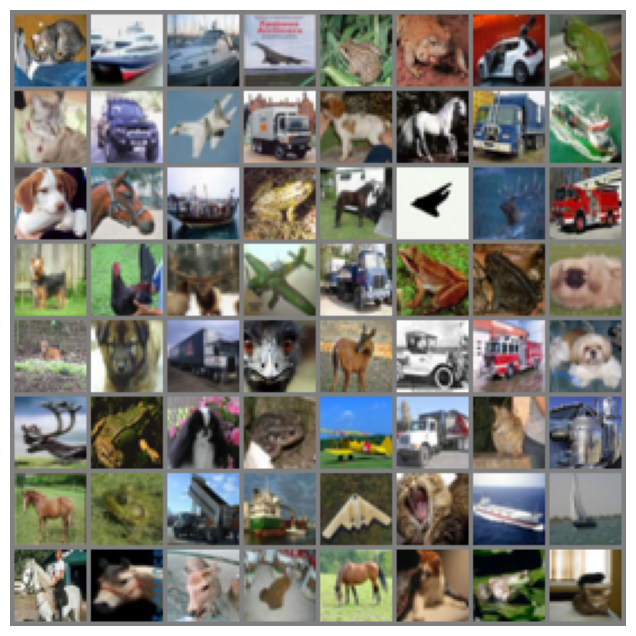

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship       automobile  
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          frog     
     dog           dog     
    horse          cat     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           c

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [10]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [11]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.642


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


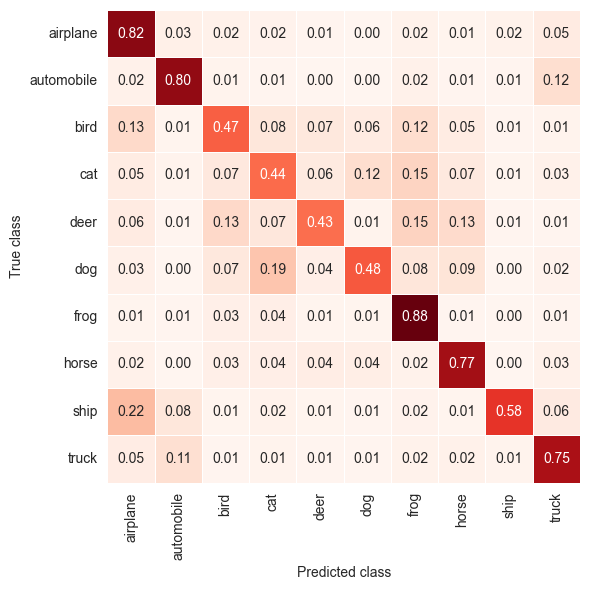

In [12]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

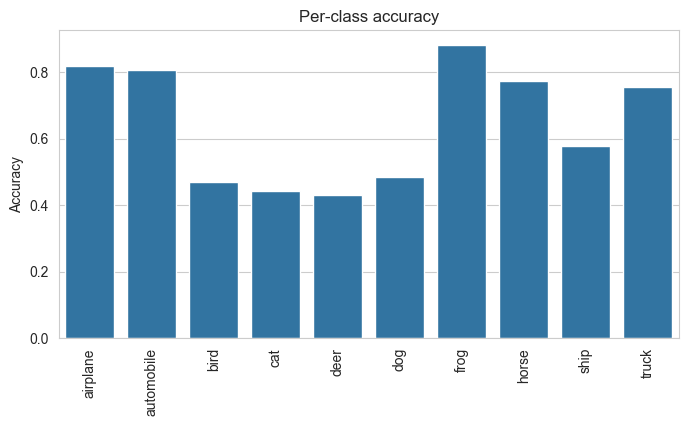

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

## Answer 1. 
From my First network which you can see above I had an average test accuracy of 0.669 which is 64.2% so already above 60%. Below I will implement an improved network architechture and try to reach 70%

### Network 2.0 

In [14]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            
            
            
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(128 * 7 * 7, 128),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(128),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 2.0 is trained on:
print("NN 2.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer



NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [15]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad() # Zero gradients.
        
        output = model(inputs) # Forward pass.
        
        loss = loss_fn(output, targets) # Compute loss.
        
        loss.backward() # Compute gradients.
        
        optimizer.step() # Update parameters.
        
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Step 500     training accuracy: 0.29003125
             test accuracy: 0.4611
Step 1000    training accuracy: 0.43162270642201833
             test accuracy: 0.5345
Step 1500    training accuracy: 0.46996875
             test accuracy: 0.586
Step 2000    training accuracy: 0.5188145068807339
             test accuracy: 0.6101
Step 2500    training accuracy: 0.5592532467532467
             test accuracy: 0.6276
Step 3000    training accuracy: 0.5695
             test accuracy: 0.6519
Step 3500    training accuracy: 0.5961021505376344
             test accuracy: 0.6577
Step 4000    training accuracy: 0.6243055555555556
             test accuracy: 0.6738
Step 4500    training accuracy: 0.61653125
             test accuracy: 0.6793
Step 5000    training accuracy: 0.6353997564935064
             test accuracy: 0.6836
Step 5500    training accuracy: 0.6658653846153846
             test accuracy: 0.6932
Step 6000    training accuracy: 0.6550625
             test accuracy: 0.7025
Step 6500    

In [16]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.754


## 1. Improving the Initial Network

My initial network achieved a test accuracy of **64.2%**, which is above the target of 60%. The model had two convolutional layers, followed by ReLU activation and max-pooling. This setup gave reasonable results, but I wanted to improve performance further to reach at least 70% accuracy by tweaking the architecture and training process.

### Key Improvements to the Network:

1. **Adding a Third Convolutional Layer**:
   - I added a third convolutional layer with 128 output channels to capture more complex features from the input. This increased the network’s ability to recognize patterns in the data and boosted its overall capacity.

2. **Batch Normalization**:
   - I used batch normalization after each convolutional layer. This helped speed up training and stabilize it by normalizing the inputs, allowing for better generalization and faster convergence.

3. **Learning Rate Reduction**:
   - I lowered the learning rate from `1e-3` to `1e-4`. This slower learning rate made training more stable, reducing oscillations in loss and helping the model converge to a better minimum.

4. **Increased Training Time**:
   - I increased the training epochs to **15,500**, which gave the model more time to fully learn from the data and optimize its parameters.

5. **Using Dropout for Regularization**:
   - I applied dropout with a rate of 0.5 in the fully connected layers to reduce overfitting. This forced the model to rely less on specific neurons and improved generalization.

### Results:

With these changes, the model achieved a test accuracy of **75.4%**, surpassing the 70% target. The additional convolutional layer, reduced learning rate, and extended training time helped the model generalize better and improved its overall performance.

---

## 2. Experiments and Results

### Experiments Conducted:

I conducted several experiments to optimize the network:

1. **Baseline Model**: 
   - Initially, with two convolutional layers and ReLU activation, the model achieved a test accuracy of **64.2%**. This was a good start, but I needed to push the accuracy higher.

2. **Adding a Third Convolutional Layer**: 
   - I added a third convolutional layer with 128 output channels, which slightly improved performance, but it wasn’t enough to hit 70%.

3. **Reducing the Learning Rate**: 
   - Reducing the learning rate from `1e-3` to `1e-4` helped stabilize training and improve accuracy.

4. **Increasing Training Epochs**: 
   - Increasing the training epochs to **15,500** gave the model more time to fully optimize, ultimately achieving a test accuracy of **75.4%**.

5. **Tweaking Dropout and Batch Normalization**: 
   - Using dropout and batch normalization together improved generalization and reduced overfitting, especially in the deeper network.

### Surprising Observations:

- The biggest surprise was how **sensitive the model was to the learning rate**. Reducing the learning rate made a huge difference in both training stability and overall accuracy.
- I also found that **Batch Normalization** played a big role in improving convergence and helped the model perform better on unseen data.
- Simply adding layers wasn’t enough—**careful tuning of the learning rate and training time** made the biggest impact on final accuracy.

---

## 3. Key Lessons and Insights

This exercise gave me several insights into improving deep learning models:

1. **Learning Rate is Key**: A small adjustment in the learning rate can have a big impact on performance. Lowering the rate helped the model train more smoothly and prevented it from oscillating.

2. **Deeper Networks Need Careful Tuning**: Adding a third convolutional layer improved the model, but I still needed to tune other hyperparameters (like the learning rate and dropout) to avoid overfitting.

3. **Batch Normalization and Dropout are Essential**: Batch normalization sped up training and improved generalization, while dropout helped reduce overfitting, especially as the model grew more complex.

4. **Longer Training Time is Sometimes Necessary**: Increasing the number of training epochs gave the model more time to optimize fully and significantly improved performance.

5. **Balance Between Complexity and Regularization**: As the network gets more complex, proper regularization (through dropout and batch normalization) becomes crucial to prevent overfitting.

In conclusion, this exercise taught me that improving a network requires not only making it deeper but also fine-tuning the learning rate, regularization, and training time for the best results.


 # ** The following is me playing around if you are not further interested then please skip ahead to the bottom of the exercise where the book exercise is ** 

# Playing around: Network version 3

## Second try at beating the test accuracy score. 

To start with I try to see if it helps with adding one more convolutional layer to bring the amount of channels up to 256

In [19]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),            
            
            
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(256 * 7 * 7, 256),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer



NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [20]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad() # Zero gradients.
        
        output = model(inputs) # Forward pass.
        
        loss = loss_fn(output, targets) # Compute loss.
        
        loss.backward() # Compute gradients.
        
        optimizer.step() # Update parameters.
        
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Step 500     training accuracy: 0.36528125
             test accuracy: 0.5063
Step 1000    training accuracy: 0.5048021788990825
             test accuracy: 0.5924
Step 1500    training accuracy: 0.54178125
             test accuracy: 0.631
Step 2000    training accuracy: 0.5975845756880734
             test accuracy: 0.6561
Step 2500    training accuracy: 0.6351461038961039
             test accuracy: 0.6712
Step 3000    training accuracy: 0.64471875
             test accuracy: 0.6883
Step 3500    training accuracy: 0.6733870967741935
             test accuracy: 0.702
Step 4000    training accuracy: 0.7032986111111111
             test accuracy: 0.7196
Step 4500    training accuracy: 0.7013125
             test accuracy: 0.7277
Step 5000    training accuracy: 0.724127435064935
             test accuracy: 0.7302
Step 5500    training accuracy: 0.7367788461538461
             test accuracy: 0.7432
Step 6000    training accuracy: 0.741375
             test accuracy: 0.7464
Step 6500    t

In [21]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.766


I achieved an even greater test accuracy of 76.6% from 75.4% before. 

To get an even better tets accuracy I add dropout layers to the third and fourth convolutional layers.

In [30]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(256 * 7 * 7, 256),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer



NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [31]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad() # Zero gradients.
        
        output = model(inputs) # Forward pass.
        
        loss = loss_fn(output, targets) # Compute loss.
        
        loss.backward() # Compute gradients.
        
        optimizer.step() # Update parameters.
        
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.343625
             test accuracy: 0.4979
Step 1000    training accuracy: 0.4905389908256881
             test accuracy: 0.5721
Step 1500    training accuracy: 0.519375
             test accuracy: 0.6152
Step 2000    training accuracy: 0.5636467889908257
             test accuracy: 0.6478
Step 2500    training accuracy: 0.604301948051948
             test accuracy: 0.6625
Step 3000    training accuracy: 0.6125625
             test accuracy: 0.6725
Step 3500    training accuracy: 0.6354166666666666
             test accuracy: 0.6832
Step 4000    training accuracy: 0.6696180555555555
             test accuracy: 0.6982
Step 4500    training accuracy: 0.665
             test accuracy: 0.7097
Step 5000    training accuracy: 0.6871956168831169
             test accuracy: 0.7221
Step 5500    training accuracy: 0.7211538461538461
             test accuracy: 0.7267
Step 6000    training accuracy: 0.70596875
             test accuracy: 0.7278
Step 6500    traini

In [34]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.774


This achieves an even better test accuracy of 77.4% 

To further improve I try using L2 regularization

In [38]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(256 * 7 * 7, 256),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay= 1e-5) # Adam optimizer



NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [39]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad() # Zero gradients.
        
        output = model(inputs) # Forward pass.
        
        loss = loss_fn(output, targets) # Compute loss.
        
        loss.backward() # Compute gradients.
        
        optimizer.step() # Update parameters.
        
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.34159375
             test accuracy: 0.5014
Step 1000    training accuracy: 0.48473337155963303
             test accuracy: 0.5684
Step 1500    training accuracy: 0.52540625
             test accuracy: 0.6147
Step 2000    training accuracy: 0.5688431766055045
             test accuracy: 0.6397
Step 2500    training accuracy: 0.612012987012987
             test accuracy: 0.6627
Step 3000    training accuracy: 0.6138125
             test accuracy: 0.6777
Step 3500    training accuracy: 0.638692876344086
             test accuracy: 0.6912
Step 4000    training accuracy: 0.6697916666666667
             test accuracy: 0.7019
Step 4500    training accuracy: 0.66825
             test accuracy: 0.7146
Step 5000    training accuracy: 0.682224025974026
             test accuracy: 0.7233
Step 5500    training accuracy: 0.6965144230769231
             test accuracy: 0.7308
Step 6000    training accuracy: 0.7066875
             test accuracy: 0.7411
Step 6500    tr

In [40]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.778


77.8% test accuracy from adding a slight L2 regularization from 77.4% without 

I try to further improve the test accuracy by using a learning rate scheduler. 

In [47]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(256 * 7 * 7, 256),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5) # Adam optimizer



NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [48]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your optimizer (already done)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ReduceLROnPlateau reduces LR when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Training loop
for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
        
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()

            valid_accuracy = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(valid_accuracy)
            
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracy}")

    # Step the scheduler based on validation accuracy
    scheduler.step(valid_accuracies[-1])

    print(f"Epoch {epoch+1}/{num_epochs} finished, current learning rate: {optimizer.param_groups[0]['lr']}")


c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Step 36000   training accuracy: 0.2897019572953737
             test accuracy: 0.4494
Step 36500   training accuracy: 0.42740625
             test accuracy: 0.5362
Epoch 1/20 finished, current learning rate: 0.0001
Step 37000   training accuracy: 0.5006888777555111
             test accuracy: 0.585
Epoch 2/20 finished, current learning rate: 0.0001
Step 37500   training accuracy: 0.5578197004608295
             test accuracy: 0.6287
Step 38000   training accuracy: 0.57528125
             test accuracy: 0.6462
Epoch 3/20 finished, current learning rate: 0.0001
Step 38500   training accuracy: 0.6112068965517241
             test accuracy: 0.6601
Epoch 4/20 finished, current learning rate: 0.0001
Step 39000   training accuracy: 0.6375612745098039
             test accuracy: 0.6835
Step 39500   training accuracy: 0.6434375
             test accuracy: 0.6919
Epoch 5/20 finished, current learning rate: 0.0001
Step 40000   training accuracy: 0.6601667789757413
             test accuracy: 0.71

In [50]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.781


This acieves an even better test accuracy of 78.1%

Trying to add another convolutional layer

In [55]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            # Added a fifth convolutional layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(512),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(512 * 7 * 7, 512),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5) # Adam optimizer

step = 0

NN 2.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [56]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your optimizer (already done)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ReduceLROnPlateau reduces LR when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Training loop
for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
        
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()

            valid_accuracy = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(valid_accuracy)
            
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracy}")

    # Step the scheduler based on validation accuracy
    scheduler.step(valid_accuracies[-1])

    print(f"Epoch {epoch+1}/{num_epochs} finished, current learning rate: {optimizer.param_groups[0]['lr']}")


c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Step 500     training accuracy: 0.37396875
             test accuracy: 0.5265
Epoch 1/20 finished, current learning rate: 0.0001
Step 1000    training accuracy: 0.5253727064220184
             test accuracy: 0.5997
Step 1500    training accuracy: 0.5554375
             test accuracy: 0.633
Epoch 2/20 finished, current learning rate: 0.0001
Step 2000    training accuracy: 0.60546875
             test accuracy: 0.6739
Epoch 3/20 finished, current learning rate: 0.0001
Step 2500    training accuracy: 0.6409293831168831
             test accuracy: 0.6904
Step 3000    training accuracy: 0.65403125
             test accuracy: 0.7056
Epoch 4/20 finished, current learning rate: 0.0001
Step 3500    training accuracy: 0.6825436827956989
             test accuracy: 0.7218
Epoch 5/20 finished, current learning rate: 0.0001
Step 4000    training accuracy: 0.7052083333333333
             test accuracy: 0.7237
Step 4500    training accuracy: 0.70834375
             test accuracy: 0.7364
Epoch 6/20 fi

In [58]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.788


78.8% test accuracy. 

I try to add another linear fully connected layer. 

In [59]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            # Added a fifth convolutional layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(512),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(512 * 7 * 7, 512),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),

            # Second fully connected layer
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),
            
            # Third fully connected layer
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),
            
            
            

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5) # Adam optimizer

step = 0

NN 3.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [60]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your optimizer (already done)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ReduceLROnPlateau reduces LR when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Training loop
for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
        
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()

            valid_accuracy = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(valid_accuracy)
            
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracy}")

    # Step the scheduler based on validation accuracy
    scheduler.step(valid_accuracies[-1])

    print(f"Epoch {epoch+1}/{num_epochs} finished, current learning rate: {optimizer.param_groups[0]['lr']}")


c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Step 500     training accuracy: 0.3115
             test accuracy: 0.493
Epoch 1/20 finished, current learning rate: 0.0001
Step 1000    training accuracy: 0.47670584862385323
             test accuracy: 0.5617
Step 1500    training accuracy: 0.5151875
             test accuracy: 0.6121
Epoch 2/20 finished, current learning rate: 0.0001
Step 2000    training accuracy: 0.5645427178899083
             test accuracy: 0.6393
Epoch 3/20 finished, current learning rate: 0.0001
Step 2500    training accuracy: 0.6171875
             test accuracy: 0.6672
Step 3000    training accuracy: 0.6245625
             test accuracy: 0.6851
Epoch 4/20 finished, current learning rate: 0.0001
Step 3500    training accuracy: 0.6514616935483871
             test accuracy: 0.696
Epoch 5/20 finished, current learning rate: 0.0001
Step 4000    training accuracy: 0.6680555555555555
             test accuracy: 0.714
Step 4500    training accuracy: 0.68028125
             test accuracy: 0.731
Epoch 6/20 finished, 

In [62]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.790


This version achieved 79% test accuracy. 

I try augmenting the loaded data by rotation, flipping and cropping. This will be applied randomly for every training batch. This will in theory help the network generalize better since it learns to be indifferent to rotations, bad crops and flips and focus on the content of the picture more.

In [64]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
# Data augmentation applied only to the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Randomly flip the image horizontally
    transforms.RandomRotation(10),               # Randomly rotate the image by up to 10 degrees
    transforms.RandomCrop(32, padding=4),        # Randomly crop the image with padding
    transforms.ToTensor(),                       # Convert the PIL image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])

# No augmentation applied to the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert the PIL image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# DataLoader with data augmentation applied to the training set
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

# DataLoader for the test set (no data augmentation)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [69]:
class Model(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1), # Changed from 0.1 to 0.25
            
            # Added a third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(128),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            
            # Added a fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(256),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer      
            
            # Added a fifth convolutional layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(512),
            activation_fn(),
            nn.Dropout2d(p=0.1), # Added a dropout layer
            nn.Flatten(),

            # Corrected input size for the fully connected layer
            nn.Linear(512 * 7 * 7, 512),  # Changed from 64 * 8 * 8 to 64 * 7 * 7
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),

            # Second fully connected layer
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),
            
            # Third fully connected layer
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation_fn(),
            nn.Dropout(p=0.5),
            
            
            

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Example usage
model = Model()

# Model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print current device
# NN 3.0 is trained on:
print("NN 3.0 is trained on:", device)
model.to(device)

# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())

loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5) # AdamW optimizer

step = 0

NN 3.0 is trained on: cuda
Output shape: torch.Size([2, 10])


In [70]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ReduceLROnPlateau scheduler to reduce LR when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Training loop
step = 0  # Initialize step counter
num_epochs = 30  # Number of epochs
for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    # Training phase
    model.train()  # Set model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute training accuracy for this batch
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        # Perform validation every validation_every_steps
        if step % validation_every_steps == 0:
            # Calculate and store training accuracy
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []  # Reset for the next set of steps

            # Validation phase
            valid_accuracies_batches = []
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():  # Disable gradient calculation for validation
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

            # Calculate total validation accuracy
            valid_accuracy = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(valid_accuracy)
            
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracy}")

    # Step the learning rate scheduler based on the latest validation accuracy
    scheduler.step(valid_accuracies[-1])

    print(f"Epoch {epoch+1}/{num_epochs} finished, current learning rate: {optimizer.param_groups[0]['lr']}")


c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Step 500     training accuracy: 0.2520625
             test accuracy: 0.4103
Epoch 1/30 finished, current learning rate: 0.0001
Step 1000    training accuracy: 0.3817373853211009
             test accuracy: 0.497
Step 1500    training accuracy: 0.50271875
             test accuracy: 0.57
Epoch 2/30 finished, current learning rate: 0.0001
Step 2000    training accuracy: 0.45043721330275227
             test accuracy: 0.584
Epoch 3/30 finished, current learning rate: 0.0001
Step 2500    training accuracy: 0.48467938311688313
             test accuracy: 0.6075
Step 3000    training accuracy: 0.59065625
             test accuracy: 0.6405
Epoch 4/30 finished, current learning rate: 0.0001
Step 3500    training accuracy: 0.5141129032258065
             test accuracy: 0.6456
Epoch 5/30 finished, current learning rate: 0.0001
Step 4000    training accuracy: 0.5277777777777778
             test accuracy: 0.6632
Step 4500    training accuracy: 0.6375
             test accuracy: 0.6722
Epoch 6/30

In [71]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.816


This achieved a really nice 81.6% test accuracy over the whole dataset. 

# Network 3.0 Optimization investigation

Throughout my experiments, I worked on improving the performance of my neural network on the CIFAR-10 dataset. At each step, I iteratively made changes to the architecture and hyperparameters to see how they impacted the test accuracy. Here's a summary of my investigations.

---

### **Iteration 1: Initial Model**

- **Architecture**: 
  - I started with 2 convolutional layers, each followed by batch normalization, ReLU, max-pooling, and dropout (p=0.1).
  - The fully connected layers had 256 units.
  
- **Optimizer**: Adam with a learning rate of `1e-4`.

- **Test Accuracy**: 0.766

---

### **Iteration 2: Dropout Adjustment**

- **Changes**:
  - I increased the dropout probability from 0.1 to 0.25 in all layers to help with regularization.
  - Then, I added a third and fourth convolutional layer with 128 and 256 channels, respectively, to give the network more capacity to learn complex features.

- **Test Accuracy**: 0.774

---

### **Iteration 3: Weight Decay**

- **Changes**:
  - I introduced weight decay (`1e-5`) in the Adam optimizer to prevent overfitting and improve regularization, especially since the model was becoming deeper.

- **Test Accuracy**: 0.778

---

### **Iteration 4: Learning Rate Scheduler**

- **Changes**:
  - I added the `ReduceLROnPlateau` learning rate scheduler, which adjusts the learning rate when the validation accuracy plateaus. This helped fine-tune the learning rate dynamically during training.

- **Test Accuracy**: 0.781

---

### **Iteration 5: Added More Layers**

- **Changes**:
  - I further deepened the network by adding a fifth convolutional layer with 512 output channels. This was an attempt to capture even more complex patterns in the data.

- **Test Accuracy**: 0.788

---

### **Iteration 6: Expanded Fully Connected Layers**

- **Changes**:
  - I added a third fully connected layer with 512 units, increasing the model's capacity in the dense layers to process the learned features from the convolutional layers.

- **Test Accuracy**: 0.790

---

### **Iteration 7: Data Augmentation**

- **Changes**:
  - To improve generalization, I tried augmenting the data using random horizontal flips, random rotations (up to 10 degrees), and random cropping with padding. This was applied to every batch during training, and it allowed the model to better handle real-world variations like shifts and rotations in images.

- **Test Accuracy**: 0.816

---

### **Key Findings**:
- Increasing the depth of the network and adjusting dropout rates helped prevent overfitting and improved performance.
- Adding data augmentation significantly boosted the model's generalization ability, leading to the best test accuracy of 0.816.
- The use of weight decay and the learning rate scheduler helped stabilize the training process and allowed for more effective learning, especially as the model became more complex.
- Incrementally adding more layers, both convolutional and fully connected, was a key strategy in enhancing the model's capacity.

---

### **Conclusion**:
Through a series of iterative changes, including adjusting the architecture, applying regularization, and implementing data augmentation, I was able to improve the model's test accuracy from 0.766 in the initial version to 0.816 in the final version. These improvements show the importance of both depth and proper regularization in building a robust model for image classification.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [72]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 3080']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

 ## **Answer**

 **I already implemented CUDA in my previous network as I could clearly tell it ran faster using my GPU**

# **Exercise from Michael Nielsen's book**

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





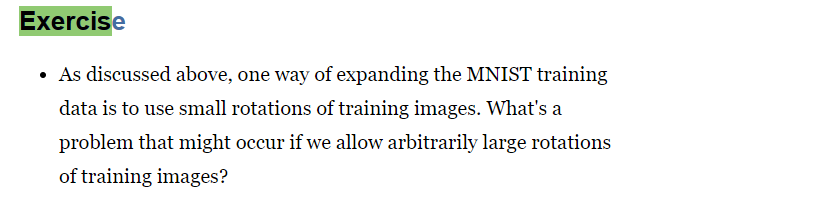

### Answer: Why Large rotations of the MNIST training set is problematic

Using small rotations to expand the MNIST dataset is a good way to help the model generalize better. But if we allow **large rotations** (like rotating by 180 degrees), it could cause some problems that actually hurt performance.

#### Main Problems:
1. **Label Confusion**:
   - Rotating digits too much can make them look like other digits. For example, if you rotate a "6" by 180 degrees, it ends up looking like a "9", and vice versa. This is going to confuse the model, making it harder to classify correctly.

2. **Losing Meaning**:
   - When digits get rotated too far, they can lose their shape entirely. For instance, if you rotate a "1" by 90 degrees, it just looks like a horizontal line, which doesn't represent "1" anymore.

3. **Inconsistent Training**:
   - Training with randomly rotated images can send mixed signals to the model. It might start thinking that a rotated "6" could be a "9", which makes it tough for the model to generalize properly to new data.

#### Why Small Rotations Work Better:
- Small rotations (like between -10 and +10 degrees) add a little variety without changing the structure of the digit too much. This way, the model can learn to handle slight variations in handwriting without getting confused by drastic changes.
